### 1. Load data

In [1]:
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.naive_bayes import MultinomialNB, ComplementNB # naive Bayes
from sklearn.linear_model import SGDClassifier # SVM
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
%matplotlib inline

In [3]:
#train_fpath = '/home/veera/LST_project/data/train_data.csv'
#test_fpath = '/home/veera/LST_project/data/test_data.csv'
data_fpath = '/home/veera/LST_project/data/full_data.csv'
labels_col_name = 'Label'
id_col_name = 'id_str'
user_id_col_name = 'user_id_str'

def download_from_csv(filename, labelled=False):
    # Helper for creating a matrix (ndarray) out of csv data
    df = pd.read_csv(filename, header=0)
    ids = df.pop(id_col_name)
    try:
        user_ids = df.pop(user_id_col_name)
    except KeyError:
        user_ids = None
    feature_names = np.asarray(df.columns.values)
    feature_names = feature_names[feature_names != 'Label']
    features = df.drop(labels_col_name, axis=1).values if labelled else df.values
    labels = df[labels_col_name].values if labelled else None       

    return features, labels, feature_names, ids, user_ids

#X_train, y_train, feature_names = download_from_csv(train_fpath)
#X_test, y_test, _ = download_from_csv(test_fpath)
X, y, feature_names, ids, _ = download_from_csv(data_fpath, labelled=True)
#print(X_train.shape, X_test.shape)
print(X.shape)
print(feature_names)

(1040, 500)
['across' 'act' 'action' 'actually' 'address' 'agenda' 'ago' 'agree'
 'agreenergoogle' 'air' 'air pollution' 'already' 'also' 'always'
 'america' 'american' 'amp' 'animal' 'announce' 'anyone' 'anything'
 'appreciate' 'apr' 'apr climate' 'april' 'area' 'around' 'article' 'ask'
 'atmosphere' 'attention' 'away' 'back' 'bad' 'bag' 'barackobama' 'base'
 'beautiful' 'become' 'begin' 'believe' 'bernie' 'best' 'biden' 'big'
 'billion' 'bin' 'biodiversity' 'bit' 'blue' 'box' 'building' 'business'
 'call' 'cant' 'car' 'carbon' 'carbon footprint' 'care' 'case' 'cause'
 'challenge' 'change' 'change denial' 'check' 'child' 'china' 'city'
 'claim' 'clean' 'clear' 'climate' 'climate action' 'climate change'
 'climate crisis' 'climate hi' 'climatechange' 'climatecrisis' 'close'
 'co' 'coal' 'come' 'community' 'company' 'consequence' 'consider'
 'content' 'continue' 'control' 'cop' 'corona' 'coronavirus' 'could'
 'country' 'course' 'covid' 'create' 'crisis' 'current' 'cut' 'date' 'day'
 'de

### 2. Explorative data analysis

class 1: 27.12%
class 2: 4.33%
class 3: 16.92%
class 4: 51.63%


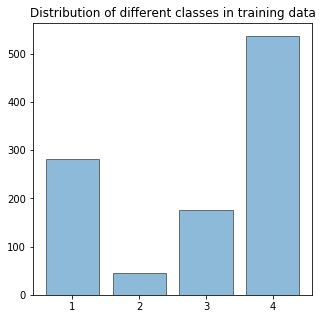

In [25]:
# count percentages of class labels
unique, counts = np.unique(y, return_counts=True)
for cl, count in zip(unique, counts):
    print('class %d: %.02f%%' % (cl, count / len(y) * 100))

# visualize class distribution
fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
hist = ax.hist(y, bins=np.arange(0.5, 5.5, 1), alpha=0.5, ec='black', rwidth=0.8)
ax.xaxis.set_ticks([i for i in range(1, 5)])
ax.set_title('Distribution of different classes in training data')

plt.show()

### 3. Define classifiers

In [5]:
# Naive Bayes
classifier_nb = ComplementNB()
# SVM, classes have equal weights (penalization)
classifier_sgd = SGDClassifier()
# SVM, automatically balanced weights
classifier_sgd_balanced = SGDClassifier(class_weight='balanced')
# SVM, custom weights
classifier_sgd_custom = SGDClassifier(class_weight={1: 20, 2: 20})

classifiers = [(classifier_nb, 'Naive Bayes'), 
               (classifier_sgd, 'SVM'), 
               (classifier_sgd_balanced, 'SVM with balanced classes'),
               (classifier_sgd_custom, 'SVM with preset weights')
              ]

In [6]:
# Oversamplers
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

### 4. Fit model and validate

In [7]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def cv(n_splits, X, y, clf, average_method, sampler=None):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    kappa = []
    for train, test in kfold.split(X, y):
        pipeline = clf
        if sampler:
            pipeline = make_pipeline(sampler, clf)
        fit = pipeline.fit(X[train], y[train])
        prediction = fit.predict(X[test])
        scores = fit.score(X[test],y[test])
        
        accuracy.append(scores)
        precision.append(precision_score(y[test], prediction, average=average_method))
        print('              positive   negative    neutral  unrelated')
        print('precision:', precision_score(y[test], prediction, average=None))
        recall.append(recall_score(y[test], prediction, average=average_method))
        print('recall:   ', recall_score(y[test], prediction, average=None))
        f1.append(f1_score(y[test], prediction, average=average_method))
        print('f1 score: ', f1_score(y[test], prediction, average=None))
        kappa.append(cohen_kappa_score(y[test], prediction))
        print('-' * 60)
    cnf_matrix = confusion_matrix(y[test], prediction)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[str(i+1) for i in range(4)], normalize=True,
                      title='Normalized confusion matrix')
    print("accuracy: %.3f (+/- %.2f)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.3f (+/- %.2f)" % (np.mean(precision), np.std(precision)))
    print("recall: %.3f (+/- %.2f)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.3f (+/- %.2f)" % (np.mean(f1), np.std(f1)))
    print('Cohen\'s kappa: %.3f (+/- %.2f)' % (np.mean(kappa), np.std(kappa)))
    plt.show()

Naive Bayes
              positive   negative    neutral  unrelated
precision: [0.425      0.20833333 0.25806452 0.83333333]
recall:    [0.425      0.71428571 0.32       0.58441558]
f1 score:  [0.425      0.32258065 0.28571429 0.6870229 ]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.46153846 0.14285714 0.38235294 0.72131148]
recall:    [0.3        0.57142857 0.52       0.57142857]
f1 score:  [0.36363636 0.22857143 0.44067797 0.63768116]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.5        0.21428571 0.33333333 0.90163934]
recall:    [0.45       0.85714286 0.32       0.71428571]
f1 score:  [0.47368421 0.34285714 0.32653061 0.79710145]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.26470588 0.17857143 0.25       0.76190476]
recall:    

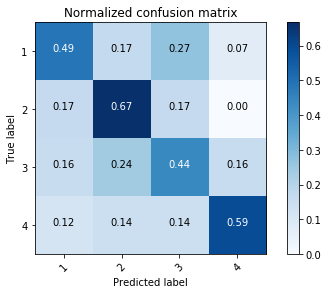



SVM
              positive   negative    neutral  unrelated
precision: [0.475      0.66666667 0.25806452 0.83333333]
recall:    [0.475      0.57142857 0.32       0.77922078]
f1 score:  [0.475      0.61538462 0.28571429 0.80536913]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.52941176 0.25       0.36363636 0.73076923]
recall:    [0.45       0.14285714 0.48       0.74025974]
f1 score:  [0.48648649 0.18181818 0.4137931  0.73548387]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.52380952 0.4        0.4        0.83116883]
recall:    [0.55       0.28571429 0.4        0.83116883]
f1 score:  [0.53658537 0.33333333 0.4        0.83116883]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.46938776 0.33333333 0.3        0.74025974]
recall:    [0.575

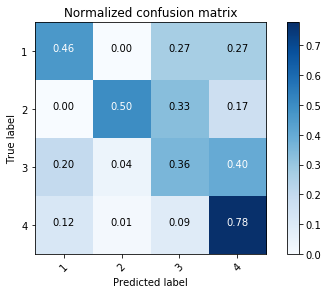



SVM with balanced classes
              positive   negative    neutral  unrelated
precision: [0.475      0.66666667 0.29032258 0.81944444]
recall:    [0.475      0.57142857 0.36       0.76623377]
f1 score:  [0.475      0.61538462 0.32142857 0.79194631]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.54054054 0.2        0.325      0.73134328]
recall:    [0.5        0.14285714 0.52       0.63636364]
f1 score:  [0.51948052 0.16666667 0.4        0.68055556]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.44186047 0.2        0.26923077 0.8       ]
recall:    [0.475      0.14285714 0.28       0.77922078]
f1 score:  [0.45783133 0.16666667 0.2745098  0.78947368]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.47916667 0.33333333 0.31818182 0.75   

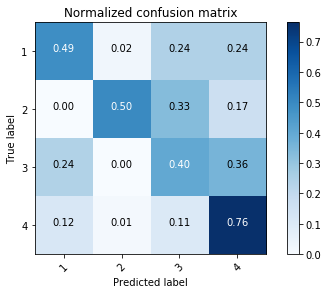



SVM with preset weights
              positive   negative    neutral  unrelated
precision: [0.46808511 0.57142857 0.26666667 0.84615385]
recall:    [0.55       0.57142857 0.32       0.71428571]
f1 score:  [0.50574713 0.57142857 0.29090909 0.77464789]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.45238095 0.         0.3125     0.73239437]
recall:    [0.475      0.         0.4        0.67532468]
f1 score:  [0.46341463 0.         0.35087719 0.7027027 ]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.42028986 0.6        0.46153846 0.80645161]
recall:    [0.725      0.42857143 0.24       0.64935065]
f1 score:  [0.53211009 0.5        0.31578947 0.71942446]
------------------------------------------------------------
              positive   negative    neutral  unrelated
precision: [0.42222222 0.25       0.24137931 0.7313432

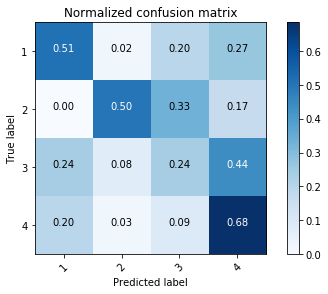

In [9]:
for clf, title in classifiers:
    print(title)
    cv(7, X, y, clf, 'macro', ros)
    print('\n')

In [10]:
print("Top 10 keywords per class:")
for clf, title in classifiers:
    print(title)
    for i in range(4):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (i+1, ", ".join(feature_names[top10])))
    print('-' * 60)

Top 10 keywords per class:
Naive Bayes
1: smart, funding climate, continue, require, google announce, change denial, agreenergoogle, humanity, vehicle emission, gop
2: walk, community, gogreen, beautiful, instead, resource, begin, space, oh, bit
3: year ago, second, within, look like, model, base, watch, information, postpone, glasgow
4: community, different, instead, apr climate, lo precip, climate hi, seem, bag, hour, precip
------------------------------------------------------------
SVM
1: require, step, climate action, billion, lie, production, important, tell, forward, earth
2: climate change, probably, great, mean, barackobama, control, realdonaldtrump, climate, people, greta
3: may, sea, start, within, scientist, single, real, fall, healthcare, around
4: didnt, india, dioxide, date, huge, turn, food, try, fear, open
------------------------------------------------------------
SVM with balanced classes
1: opportunity, billion, climatecrisis, require, lie, important, tell, produc

### 5. Apply the model

chicago
class 1: 15.39%
class 2: 2.32%
class 3: 12.81%
class 4: 69.48%


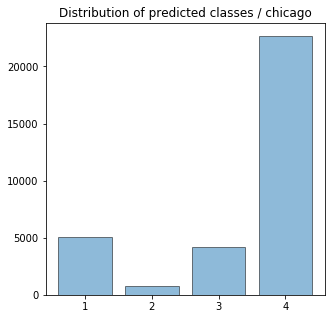

houston
class 1: 14.68%
class 2: 2.34%
class 3: 13.02%
class 4: 69.96%


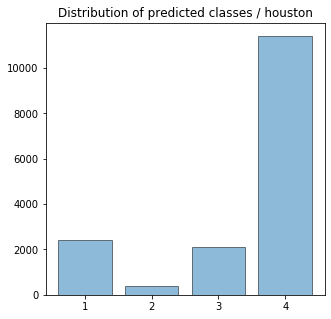

miami
class 1: 14.42%
class 2: 2.05%
class 3: 10.58%
class 4: 72.95%


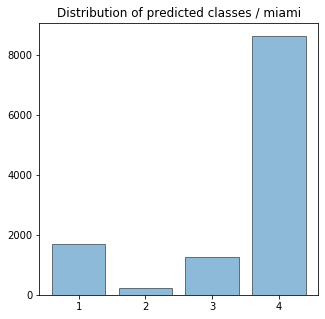

philadelphia
class 1: 16.60%
class 2: 2.39%
class 3: 13.56%
class 4: 67.45%


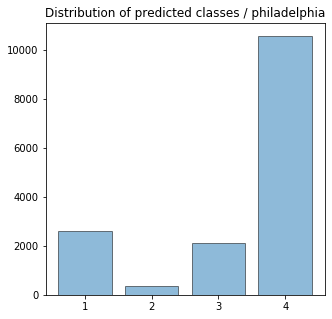

phoenix
class 1: 16.53%
class 2: 2.06%
class 3: 12.47%
class 4: 68.94%


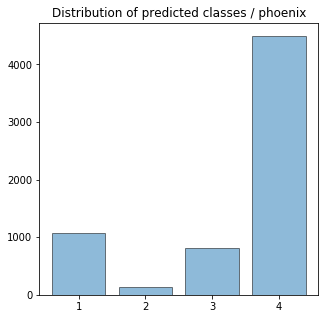

In [28]:
cities = ['chicago', 'houston', 'miami', 'philadelphia', 'phoenix']

classifier = classifier_sgd_balanced
sampler = ros

pipeline = classifier
if sampler:
    pipeline = make_pipeline(sampler, classifier)
fit = pipeline.fit(X, y)
for city in cities:
    print(city)
    f = '/home/veera/LST_project/data/%s/full_data_%s.csv' % (city, city)
    try:
        X_new, _, _, ids, user_ids = download_from_csv(f)
        y_new_pred = fit.predict(X_new)
        outfile = op.join(op.dirname(f), 'predictions_' + city +'.csv')
        df = pd.DataFrame(np.c_[ids, user_ids, y_new_pred], columns=[id_col_name, user_id_col_name, 'Label'])
        df.to_csv(outfile, index=False)
        
        # count percentages of class labels
        unique, counts = np.unique(y_new_pred, return_counts=True)
        for cl, count in zip(unique, counts):
            print('class %d: %.02f%%' % (cl, count / len(y_new_pred) * 100))
        
        # visualize class distribution
        fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
        hist = ax.hist(y_new_pred, bins=np.arange(0.5, 5.5, 1), alpha=0.5, ec='black', rwidth=0.8)
        ax.xaxis.set_ticks([i for i in range(1, 5)])
        ax.set_title('Distribution of predicted classes / %s' % city)
        plt.show()
    except FileNotFoundError:
        print('file', f, 'not found')